<a href="https://colab.research.google.com/github/rajeev-shivaram/PyTorch101/blob/master/Image_Recognition_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

1. training loader : is used to specify training batches, for every epoch, we passed through the dataset and 600000 is too big so we divide into batches
  with batch_size=100, it'll take 600 epochs to complete one iteration
  we set shuffle True as we dont want it to get stuck at a local minima, also batch_size depends on the GPU currently in use and also the size of dataset.

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# 1
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)

1 before converting to numpy array, we will clone it to create a new copy of tensor and use detach


2 now we have a numpy array which represents 1st as color channel and 2nd & 3rd as height and width (1, 28, 28)
  but to plot our image we need to have it in (h, w, colorChannel)
  here, we swap axis 0, for axis 1, axis 1 for 2, and axis 0 in end.
  
 3 since we had normalized the image we de-normalize the image;normalizing consists of subtracting the mean and dividing by std deviation so denorm has..
 
 4 previously normalizing converted our image from range 0->1 to -1->1 and set the image to 0->1 we can set, applying a clip func for a min value of 0 to max val of 1.

In [0]:
def im_convert(tensor):
  """to plot the dataset, we make use of an numpy array"""
  # 1 
  image = tensor.clone().detach().numpy()
  
  # 2
  image = image.transpose(1, 2, 0)
  print(image.shape)
  # 3
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  
  # 4
  image = image.clip(0, 1)
  
  return image
  

Wrap training_loader in an iter so we can iterate through it
and next element is accessed by calling next on our data iter

each iter can be split into images and labels

---



(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


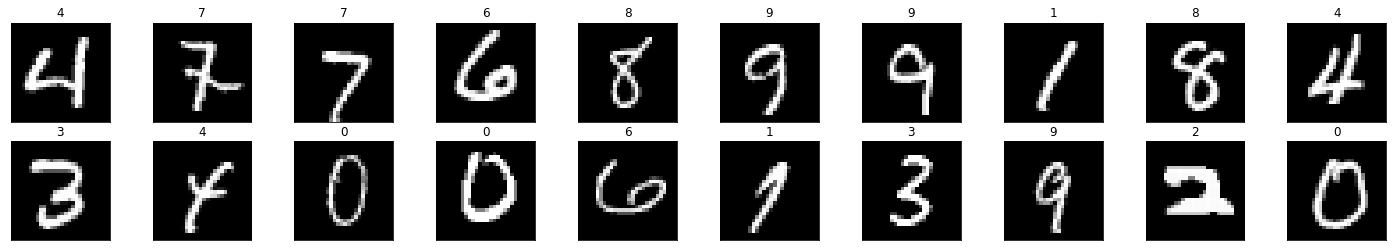

In [0]:
# 1
dataiter = iter(training_loader)

# 2
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))  # width and height of images

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # no of rows and 10 columns per row (10 images total), index and must be between 1 and 20
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

1. Te activation function is not applied to the last layer. what we get is the raw output of the network often called the score whicg=h is significatly used in calculating the cross-entropy loss of muticlass dataset namely nn.CrossEntropyLoss -> used for multiclass classification; combination of log_softmax + NegitiveLogLikelyhoodLoss/NLLLoss()

In [0]:
class Classifier(nn.Module):
  
  def __init__(self, D_in, H1, H2, D_out):
    """Define the Layers of the model"""
    super(Classifier, self).__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
   
  def forward(self, x):
    """Define the prediction function of model"""
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)  # 1
    return x

In [0]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
epochs = 12
running_losses_history = []
running_correct_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1) # color channel, inputs (28*28)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    
  else:
    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_losses_history.append(epoch_loss)
    print(f"TrainingLoss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}")
    

TrainingLoss: 0.4363, acc: 87.2333
TrainingLoss: 0.2106, acc: 93.7217
TrainingLoss: 0.1537, acc: 95.3583
TrainingLoss: 0.1257, acc: 96.1050
TrainingLoss: 0.1046, acc: 96.8550
TrainingLoss: 0.0888, acc: 97.2767
TrainingLoss: 0.0814, acc: 97.4467
TrainingLoss: 0.0720, acc: 97.7133
TrainingLoss: 0.0619, acc: 97.9950
TrainingLoss: 0.0603, acc: 98.0233
TrainingLoss: 0.0540, acc: 98.2600
TrainingLoss: 0.0490, acc: 98.3800


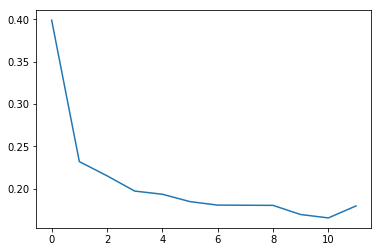

In [0]:
plt.plot(running_losses_history, label='Training Loss')